In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/O3aPISN`


In [2]:
using Cosmology
using HDF5
using LaTeXStrings
using LinearAlgebra
using MCMCChains
using O3aPISN
using PISNMassFunctions
using Printf
using StatsBase
using StatsPlots
using Turing
using Unitful
using UnitfulAstro

default(fmt=:png)

In [3]:
var_names = [:R, :a, :b, :c, :beta, :mPISN, :mBH_max, :sigma, :h, :ΩM, :lambda, :z_p, :kappa]
trace = h5open(joinpath(@__DIR__, "..", "chains", "chains_cosmology.h5"), "r") do f
    read(f, Chains)
end
trace[var_names]

Chains MCMC chain (1000×13×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = R, a, b, beta, c, h, kappa, lambda, mBH_max, mPISN, sigma, z_p, ΩM
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           R    0.6747    0.2884     0.0091    0.0160    621.8758    1.0032
           a    1.3559    0.9855     0.0312    0.0706    165.8571    1.0020
           b   -0.0920    1.9699     0.0623    0.1641    120.4632    1.0359
        beta    1.8269    0.8450     0.0267    0.0388    660.5095    0.9992
           c    2.8705    1.0519     0.0333    0.0260    690.4081    1.0000
           h    0.6063    0.1449     0.0046    0.0039    757.1336    0.9991
       kappa    8.1416    1.5841     0.0501    0.0677    752.0082    1.0097
      lambda    5.1755    1.3053     0.0413    0.0549    72

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364


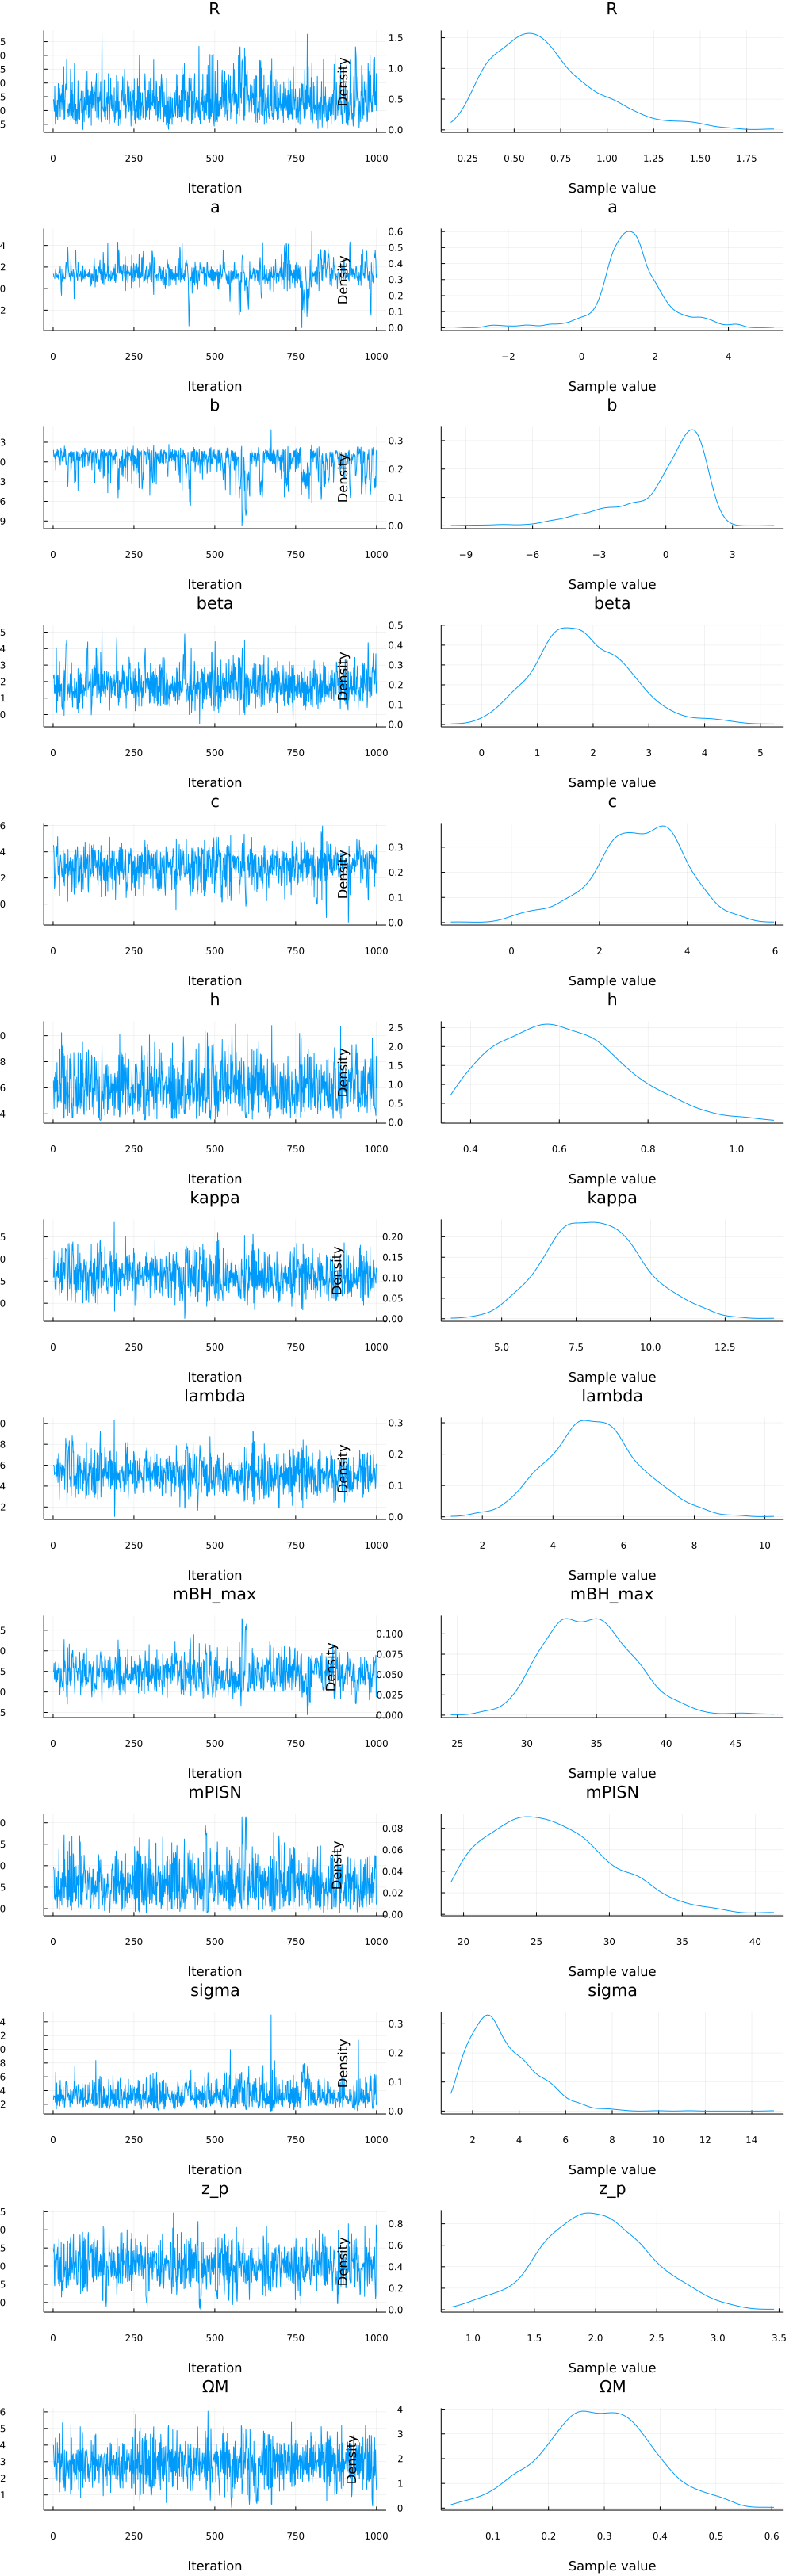

In [4]:
plot(trace[var_names])

min Neff / Nobs = 11.3


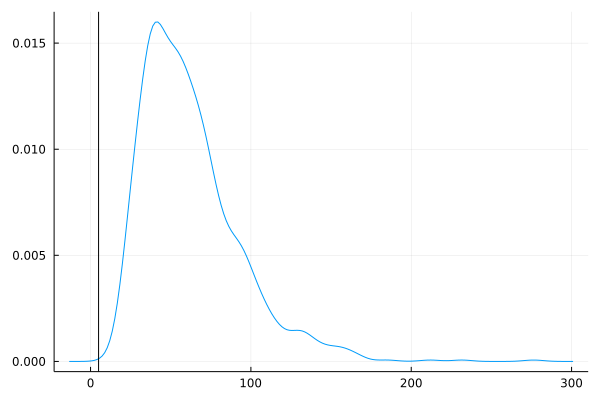

In [5]:
Nevt = length(namesingroup(trace, :m1s))
println(@sprintf("min Neff / Nobs = %.1f", minimum(vec(trace[:Neff])) / Nevt))
@df trace density(:Neff ./ Nevt, label=nothing)
vline!([5], color=:black, label=nothing)

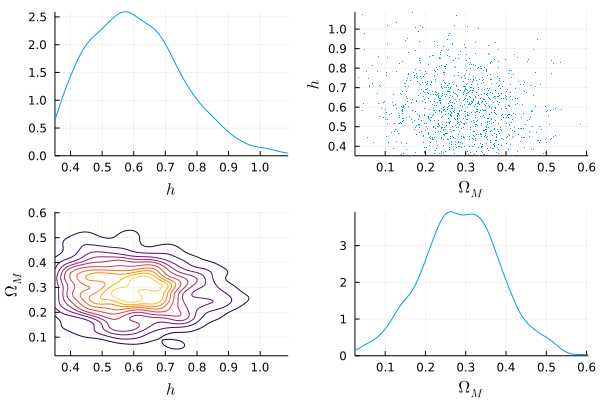

In [6]:
@df trace cornerdensity((:h, :ΩM), labels=(L"h", L"\Omega_M"))

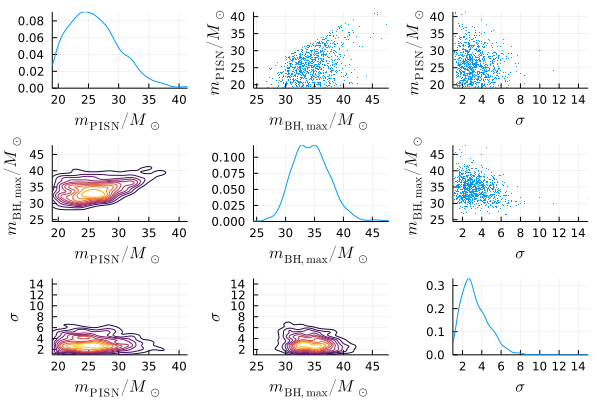

In [7]:
@df trace cornerdensity((:mPISN, :mBH_max, :sigma), labels=(L"m_\mathrm{PISN} / M_\odot", L"m_\mathrm{BH,max} / M_\odot", L"\sigma"))

In [8]:
log_dNs = log_dNdtheta_cosmology_fn(trace)
dNdVdlogm1dqdVdts = map(log_dNs, trace[:R], trace[:h], trace[:ΩM]) do log_dN, R, h, ΩM
    c = cosmology(h=h, OmegaM=ΩM, w0=-1.0)
    (m1, q, z) -> begin 
        m1d = m1*(1+z)
        dL = ustrip(u"Gpc", luminosity_dist(c, z))
        
        dN = exp(log_dN(m1d, q, dL)) # dN/d(m1d)d(q)d(dL)
        
        # d(m1d)/d(m1)*d(dL)/d(z)
        jac = (1+z)*ustrip(u"Gpc", comoving_transverse_dist(c, z) + (1+z)*hubble_dist(c, 0)/Cosmology.E(c, z))
        
        # dN/dlog(m1)dqdVdt
        R*m1*dN*jac*(1+z)/(4*pi*ustrip(u"Gpc^3", Cosmology.comoving_volume_element(c, z)))
    end
end;

Find the best-measured mass, mass ratio, and redshift.

33.60179426915136
0.8131428571428572
0.36342511413217776


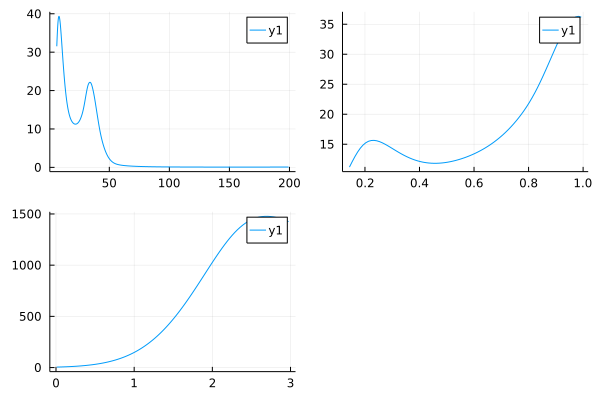

In [9]:
m0 = 35.0
q0 = 0.8
z0 = 0.4

m = exp.(log(5.01/q0):0.01:log(200.0))
q = collect(5.01/m0:0.01:1.0)
z = expm1.(log(1.0):0.01:log(1.0+3.0))[2:end]
dNdlogm1dVdt = map(dN -> dN.(m, q0, z0), dNdVdlogm1dqdVdts)
dNdqdVdt = map(dN -> dN.(m0, q, z0), dNdVdlogm1dqdVdts)
dNdVdt = map(dN -> dN.(m0, q0, z), dNdVdlogm1dqdVdts)

pm = plot(m, mean(dNdlogm1dVdt))
pq = plot(q, mean(dNdqdVdt))
pz = plot(z, mean(dNdVdt))

im = argmin(std([log.(dN) for dN in dNdlogm1dVdt]))
iq = argmin(std([log.(dN) for dN in dNdqdVdt]))
iz = argmin(std([log.(dN) for dN in dNdVdt]))

println(m[im])
println(q[iq])
println(z[iz])

plot(pm, pq, pz)

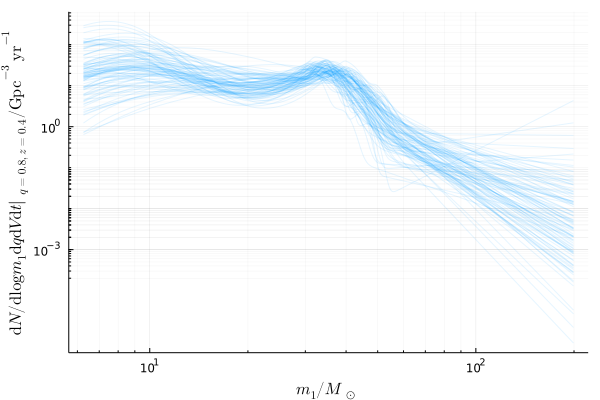

In [10]:
p = plot(yscale=:log10, xscale=:log10, minorgrid=true, xlabel=L"m_1 / M_\odot", ylabel=@sprintf("\$\\left. \\mathrm{d}N/\\mathrm{d} \\log m_1 \\mathrm{d} q \\mathrm{d} V \\mathrm{d} t \\right|_{q=%.1f, z=%.1f} / \\mathrm{Gpc}^{-3} \\, \\mathrm{yr}^{-1}\$", q0, z0))
for _ in 1:100
    p = plot!(m, sample(dNdlogm1dVdt), color=1, alpha=0.1, label=nothing)
end
p

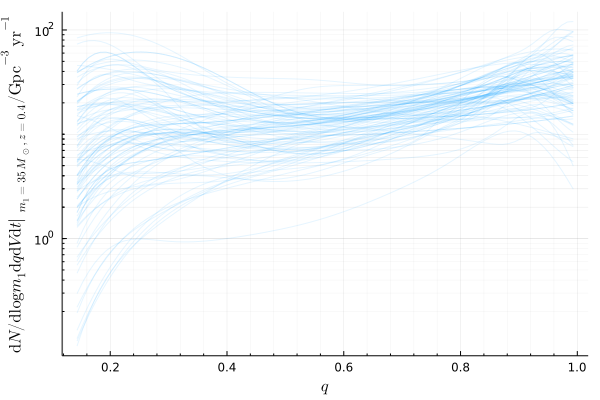

In [11]:
p = plot(yscale=:log10, minorgrid=true, xlabel=L"q", ylabel=@sprintf("\$\\left. \\mathrm{d}N/\\mathrm{d} \\log m_1 \\mathrm{d} q \\mathrm{d} V \\mathrm{d} t \\right|_{m_1=%.0f \\, M_\\odot, z=%.1f} / \\mathrm{Gpc}^{-3} \\, \\mathrm{yr}^{-1}\$", m0, z0))
for _ in 1:100
    p = plot!(q, sample(dNdqdVdt), color=1, alpha=0.1, label=nothing)
end
p

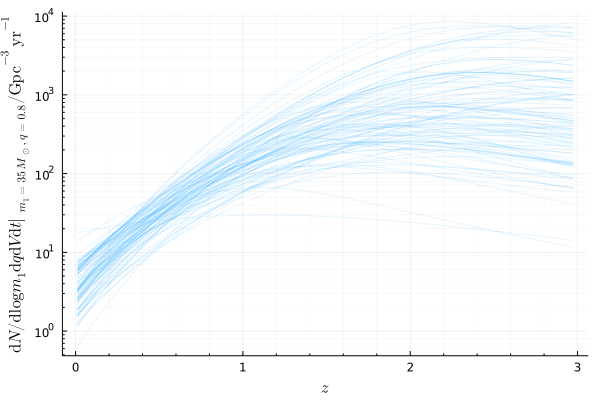

In [12]:
p = plot(yscale=:log10, minorgrid=true, xlabel=L"z", ylabel=@sprintf("\$\\left. \\mathrm{d}N/\\mathrm{d} \\log m_1 \\mathrm{d} q \\mathrm{d} V \\mathrm{d} t \\right|_{m_1=%.0f \\, M_\\odot, q=%.1f} / \\mathrm{Gpc}^{-3} \\, \\mathrm{yr}^{-1}\$", m0, q0))
for _ in 1:100
    p = plot!(z, sample(dNdVdt), color=1, alpha=0.1, label=nothing)
end
p

In [13]:
Hzs = map(trace[:h], trace[:ΩM]) do h, ΩM
    c = cosmology(h=h, OmegaM=ΩM, w0=-1.0)
    h .* [Cosmology.E(c, zz) for zz in z]
end;

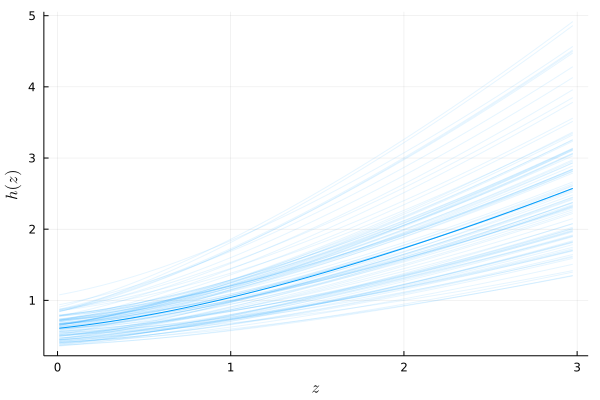

In [14]:
p = plot(xlabel=L"z", ylabel=L"h(z)")
for _ in 1:100
    p = plot!(z, sample(Hzs), label=nothing, color=1, alpha=0.1)
end
p = plot!(z, mean(Hzs), label=nothing, color=1)
p

In [15]:
Hzs_prior = Vector{Float64}[]
Omh2_prior = Float64[]
for _ in 1:1000
    h = rand(truncated(Normal(0.7, 0.2), 0.35, 1.4))
    ΩM = rand(truncated(Normal(0.3, 0.1), 0.0, 1.0))
    w = -1.0 # rand(truncated(Normal(-1.0, 0.2), -1.5, -0.5))

    c = cosmology(h=h, OmegaM=ΩM, w0=w)
    push!(Hzs_prior, [h*Cosmology.E(c, zz) for zz in z])
    push!(Omh2_prior, ΩM*h*h)
end

sigma_H = std([log.(H) for H in Hzs])
i = argmin(sigma_H)
println(@sprintf("Var(log(h(z))) minimized at z = %.3f with value %.2f", z[i], sigma_H[i]))

sigma_H_prior = std([log.(H) for H in Hzs_prior])
i = argmin(sigma_H_prior)
println(@sprintf("Prior Var(log(h(z))) minimized at z = %.3f with value %.2f", z[i], sigma_H_prior[i]))

Var(log(h(z))) minimized at z = 0.246 with value 0.24
Prior Var(log(h(z))) minimized at z = 0.010 with value 0.26


In [16]:
function median_lower_upper(z, trace)
    ll, l, m, h, hh = map([0.025, 0.16, 0.5, 0.84, 0.975]) do q
        [quantile(vec([t[i] for t in trace]), q) for i in eachindex(z)]
    end
    ll, l, m, h, hh
end

median_lower_upper (generic function with 1 method)

In [17]:
hll, hl, hm, hh, hhh = median_lower_upper(z, Hzs)
hpll, hpl, hpm, hph, hphh = median_lower_upper(z, Hzs_prior);

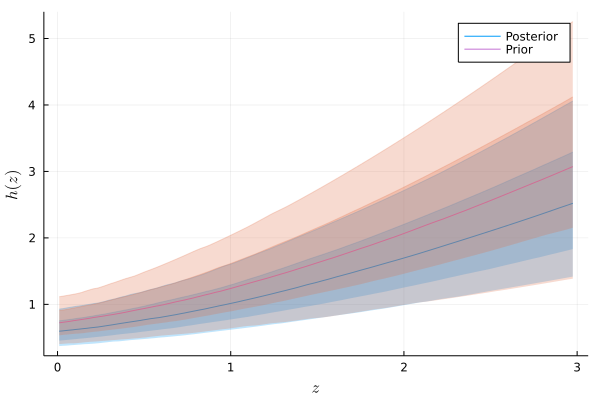

In [18]:
p = plot(z, hm, label="Posterior", xlabel=L"z", ylabel=L"h(z)")
p = plot!(z, hh, fill_between=hl, label=nothing, color=1, alpha=0.25)
p = plot!(z, hhh, fill_between=hll, label=nothing, color=1, alpha=0.25)

p = plot!(z, hpm, label="Prior")
p = plot!(z, hph, fill_between=hpl, label=nothing, color=2, alpha=0.25)
p = plot!(z, hphh, fill_between=hpll, label=nothing, color=2, alpha=0.25)
p

In [19]:
nevt = length(namesingroup(trace, :m1s))
nd, _, nc = size(trace)

m1ds = zeros(nd, nevt, nc)
dls = zeros(nd, nevt, nc)
d = zeros(nd, length(z), nc)
mmax = zeros(nd, nc)
for k in 1:nc
    for i in 1:nd
        c = cosmology(h=trace[:h][i,k], OmegaM=trace[:ΩM][i,k], w0=-1.0)
        m1ds[i,:,k] = [trace["m1s[$j]"][i,k]*(1+trace["zs[$j]"][i,k]) for j in 1:nevt]
        dls[i,:,k] = [ustrip(u"Gpc", luminosity_dist(c, trace["zs[$j]"][i,k])) for j in 1:nevt]
        d[i,:,k] = [ustrip(u"Gpc", luminosity_dist(c, zz)) for zz in z]
        mmax[i,k] = trace[:mBH_max][i,k]        
    end
end

m1ds_mean = vec(mean(m1ds, dims=(1,3)))
dls_mean = vec(mean(dls, dims=(1,3)))
m1ds_std = vec(std(m1ds, dims=(1,3)))
dls_std = vec(std(dls, dims=(1,3)));

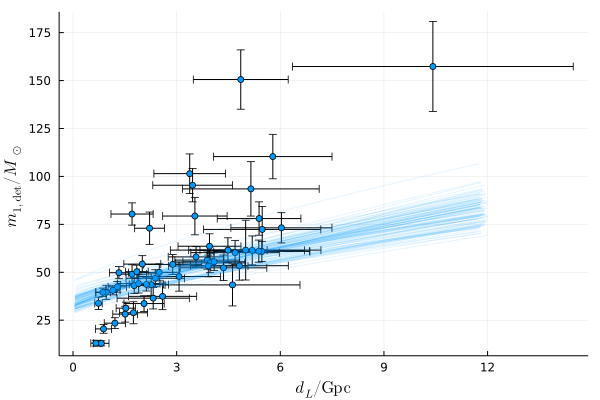

In [20]:
p = scatter(dls_mean, m1ds_mean, xerr=dls_std, yerr=m1ds_std, xlabel=L"d_L / \mathrm{Gpc}", ylabel=L"m_{1,\mathrm{det}} / M_\odot", label=nothing)
for _ in 1:100
    i = rand(1:size(d,1))
    k = rand(1:size(d,3))
    mask = d[i,:,k] .< 12
    p = plot!(d[i,:,k][mask], mmax[i,k].*(1 .+ z[mask]), color=1, alpha=0.1, label=nothing)
end
p

How well do we do at improving on the prior where or $H(z)$ is best-constrained?

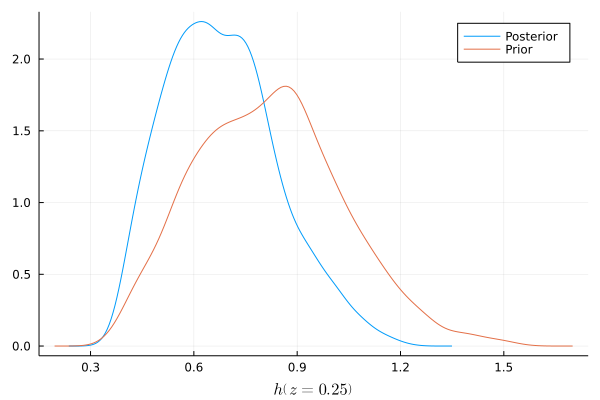

In [21]:
imin = argmin(sigma_H)
h_at_hmin = map(x -> x[imin], Hzs)
hp_at_hmin = map(x -> x[imin], Hzs_prior)
density(h_at_hmin, label="Posterior")
density!(hp_at_hmin, label="Prior")
xlabel!(@sprintf("\$h\\left( z = %.2f \\right)\$", z[imin]))

There should be some improvement in $\Omega_M h^2$:

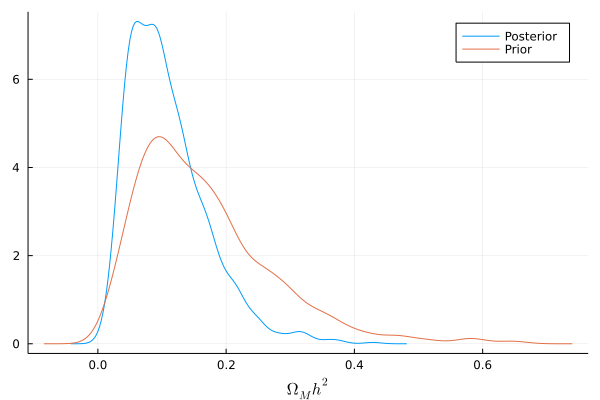

In [22]:
@df trace density(:ΩM .* :h.^2, label="Posterior")
density!(Omh2_prior, label="Prior")
xlabel!(L"\Omega_M h^2")

What if we re-weight to match [Planck (2018)](https://ui.adsabs.harvard.edu/abs/2020A%26A...641A...6P/abstract) $\Omega_M h^2$ and $w = -1$?

In [23]:
function wt(h, Om; factor_Om=1)
    prior_wt = pdf(Normal(0.7, 0.2), h)*pdf(Normal(0.3, 0.1), Om)
    new_wt = pdf(Normal(0.1428, factor_Om*0.0011), Om*h*h)*h*h
    new_wt / prior_wt
end
wts = [wt(h, Om; factor_Om=8) for (h, Om) in zip(trace[:h], trace[:ΩM])]
Neff = sum(wts)^2 / sum(wts.*wts)

19.549805593185482

In [24]:
mu_h = mean(wts.*trace[:h])/mean(wts)
std_h = sqrt(mean(wts.*(trace[:h] .- mu_h).^2)/mean(wts))
mu_h, std_h

(0.7381447070457186, 0.1857545979677195)

As Jiani has been saying, this doesn't do much:

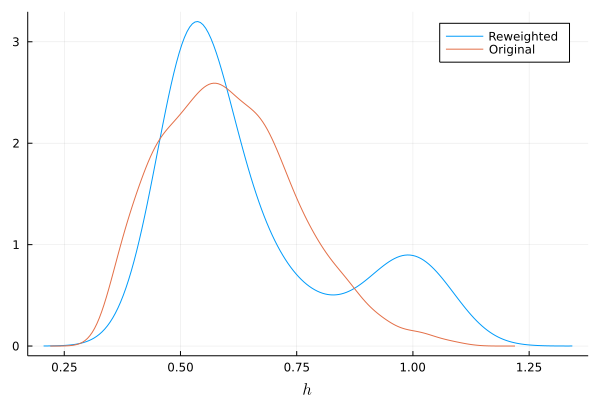

In [25]:
density(sample(trace[:h], weights(wts), 20), label="Reweighted")
density!(trace[:h], label="Original")
xlabel!(L"h")